In [5]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from config import Config
from caption_util import plot_caption_pred
from datetime import datetime
from fliker_comment_tokenizer import FlikerCommentTokenizer
from lm_test_dataset import LMTestDataset
from img_comment_dataset import ImgCommentDataset
from img_embedding import ImageEmbedding
from img_transformer import ImgTransformer
from img_util import show_img_tensor_CHW, inverse_img_aug
from model_util import count_parameters, load_model
from pathlib import Path
from text_token_embedding import TextTokenEmbedding
from text_casual_mask_transformer import TextMaskedTransformer
from torch.utils.tensorboard import SummaryWriter
from train_settings import TrainSettings
from tqdm import tqdm
from vlm_model import ImgLanguageModel
from vlm_train import train_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import DataLoader
import torchvision.transforms.functional as VF

plt.rcParams["savefig.bbox"] = 'tight'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config = Config()
train_settings = TrainSettings()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_2_20241004_030026_234476.pt"
target_model = load_model(config=config, model_file=model_file, device=device)

2024-10-04 22:03:40,640 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-10-04 22:03:40,640 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
2024-10-04 22:03:41,230 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-10-04 22:03:41,230 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
dict_keys(['epoch', 'global_step', 'total_steps', 'model_state_dict', 'optimizer_state_dict', 'loss', 'config', 'train_settings'])


In [8]:
lm_test_dataset = LMTestDataset(config)
print(f"test_dataset:  {len(lm_test_dataset)}")

# Data Loader
BATCH_SIZE = 10
lm_test_dataloader = DataLoader(lm_test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"test_data_loader:  {len(lm_test_dataloader)}")

2024-10-04 22:03:44,372 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-10-04 22:03:44,372 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
test_dataset:  2
test_data_loader:  1


2024-10-04 22:03:44,413 - lm_test_dataset - INFO - missing comment for image: /Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/3212671393.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5878845..2.145897].


batch_aug_img_tensor1: torch.Size([3, 224, 224])


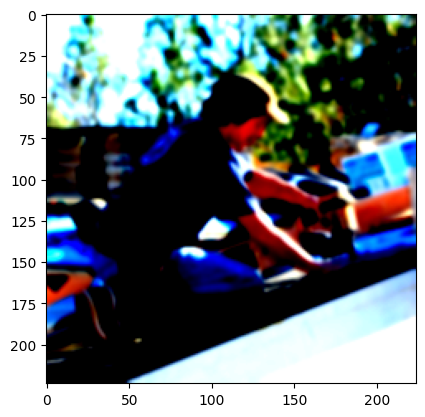

In [9]:
(
    batch_aug_img_tensor1,
    batch_aug_img_tensor2,
    batch_img_id_tensor,
    batch_text_tensor,
    batch_text_mask_tensor,
) = next(iter(lm_test_dataset))


batch_aug_img_tensor1 = batch_aug_img_tensor1.to(device)
batch_aug_img_tensor2 = batch_aug_img_tensor2.to(device)
batch_img_id_tensor = batch_img_id_tensor.to(device)
batch_text_tensor = batch_text_tensor.to(device)
batch_text_mask_tensor = batch_text_mask_tensor.to(device)


print(f"batch_aug_img_tensor1: {batch_aug_img_tensor1.shape}")
show_img_tensor_CHW(batch_aug_img_tensor1.cpu())

In [10]:
def predict_next_token(
    target_model: nn.Module,
    lm_test_dataset: LMTestDataset,
    lm_test_dataloader: DataLoader,
):
    with torch.no_grad():
        for idx, data in tqdm(
            enumerate(lm_test_dataloader), total=len(lm_test_dataloader)
        ):
            (
                batch_aug_img_tensor1,
                batch_aug_img_tensor2,
                batch_img_id_tensor,
                batch_text_tensor,
                batch_text_mask_tensor,
            ) = data

            batch_aug_img_tensor1 = batch_aug_img_tensor1.to(device)
            batch_aug_img_tensor2 = batch_aug_img_tensor2.to(device)
            batch_img_id_tensor = batch_img_id_tensor.to(device)
            batch_text_tensor = batch_text_tensor.to(device)
            batch_text_mask_tensor = batch_text_mask_tensor.to(device)
            # print(f"batch_text_tensor: {batch_text_tensor}")

            (
                img_img_loss,
                img_text_loss,
                text_img_loss,
                img_img_contrastive_prob,
                img_text_contrastive_prob,
                text_img_contrastive_prob,
                lm_loss,
                lm_logit,
            ) = target_model(
                batch_aug_img_tensor1=batch_aug_img_tensor1,
                batch_aug_img_tensor2=batch_aug_img_tensor2,
                batch_text_tensor=batch_text_tensor,
                batch_text_mask_tensor=batch_text_mask_tensor,
                batch_img_id_tensor=batch_img_id_tensor,
            )

            # print(f"lm_logit: {lm_logit.size()}")

            B = lm_logit.size(0)
            valid_target_text_token_length, valid_target_text_index = torch.max(
                batch_text_mask_tensor, dim=1, keepdim=False
            )
            for bi, token_length, img_id in zip(
                torch.arange(B, device=device),
                valid_target_text_token_length,
                batch_img_id_tensor,
            ):
                assert token_length > 0
                target_text_logits = lm_logit[bi][token_length]
                prdict_token_max = torch.argmax(target_text_logits, dim=-1)
                prdict_caption = lm_test_dataset.text_tokenizer.decode(prdict_token_max)
                # print(f"img_id: {img_id}")
                # print(f"target_text_logits: {target_text_logits.size()}")
                # print(f"prdict_token_max: {prdict_token_max}")
                # print(f"prdict_caption: {prdict_caption}")

                lm_test_dataset.update_comment(img_id, prdict_caption)

In [11]:
for i in range(30):
    predict_next_token(
        target_model=target_model,
        lm_test_dataset=lm_test_dataset,
        lm_test_dataloader=lm_test_dataloader,
    )


print(json.dumps(lm_test_dataset.get_img_comment()))

  0%|          | 0/1 [00:00<?, ?it/s]

2024-10-04 22:03:44,601 - lm_test_dataset - INFO - missing comment for image: /Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/3212671393.jpg
2024-10-04 22:03:44,613 - lm_test_dataset - INFO - missing comment for image: /Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/3273585735.jpg


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

[{'image': PosixPath('/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/3212671393.jpg'), 'comment': 'tiger trim s.s.\nboard.\n\n......................'}, {'image': PosixPath('/Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images/3273585735.jpg'), 'comment': 'tiger trim s.s.\nuniform\nball...stadium..................'}]


2024-10-04 22:03:53,775 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-10-04 22:03:53,775 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True
2024-10-04 22:03:58,210 - fliker_comment_tokenizer - INFO - tokens: 10000
2024-10-04 22:03:58,210 - fliker_comment_tokenizer - INFO - tokenizer.is_fast: True


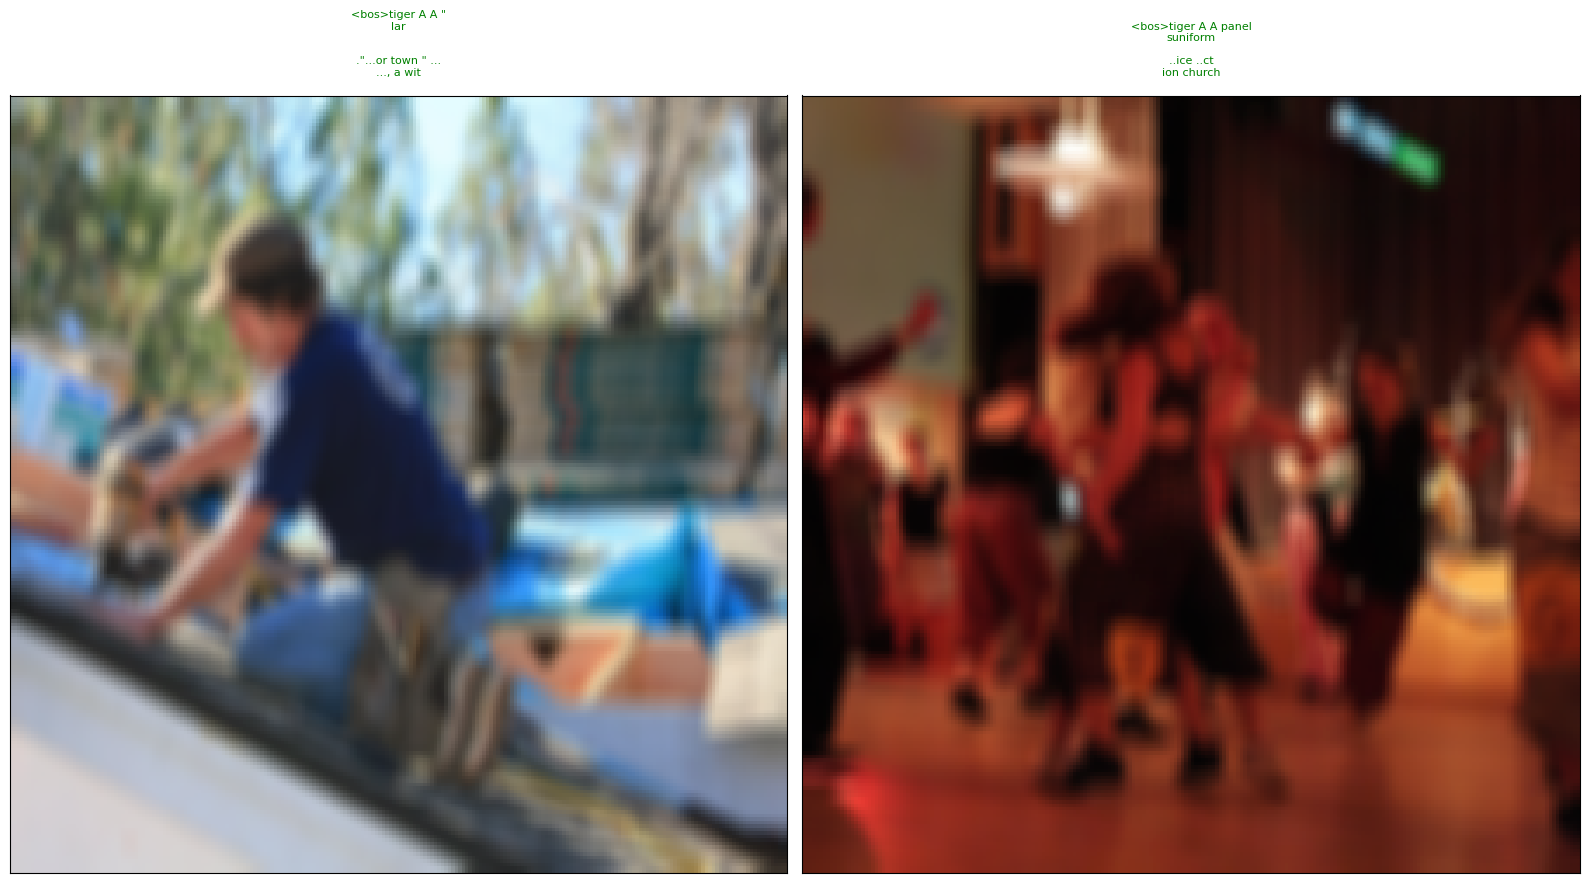

In [12]:
img_file_paths = [data_item.image_name for data_item in lm_test_dataset.data_items]

target_model.eval()
with torch.no_grad():
    fig = plot_caption_pred(
        img_langualge_model=target_model,
        img_file_paths=img_file_paths,
        device=device,
    )